In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GaussianNoise, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Conv1D, GlobalAveragePooling2D
import os
import PIL
import scipy
import cv2
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from sklearn.model_selection import train_test_split
import shutil

In [8]:
BATCH_SIZE = 8
IMG_SIZE = 224
EPOCH = 10

root_dir = 'data/train/'

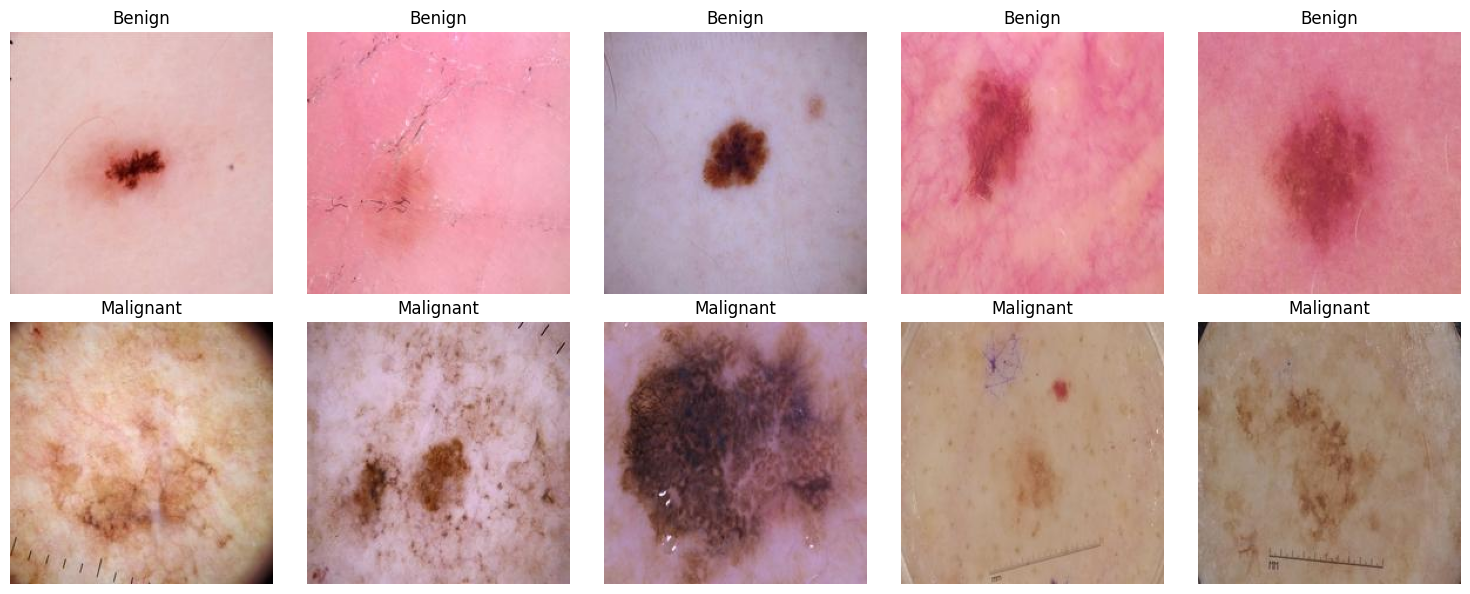

In [9]:
def display_image_from_categories(dir, num_img=5):
    categories = os.listdir(dir)
    fig, ax = plt.subplots(len(categories), num_img, figsize=(num_img*3, len(categories)*3))
    
    for i, category in enumerate(categories):
        category_dir = os.path.join(dir, category)
        images = os.listdir(category_dir)[:num_img]
        
        for j, image in enumerate(images):
            img_path = os.path.join(category_dir, image)
            img = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
            
            ax[i,j].imshow(img)
            ax[i,j].set_title(category)
            ax[i,j].axis('off')
            
    plt.tight_layout()
    plt.show()
            
     
        
display_image_from_categories(root_dir)

In [15]:
# Get the list of subdirectories in the original training directory
subdirectories = os.listdir(root_dir)

# Split the subdirectories into training and validation sets
train_subdirs, validation_subdirs = train_test_split(subdirectories, test_size=0.2, random_state=42)

# Create directories for training and validation data
train_data_dir = 'path/to/train_data'
os.makedirs(train_data_dir, exist_ok=True)

validation_data_dir = 'path/to/validation_data'
os.makedirs(validation_data_dir, exist_ok=True)

# Move images to the corresponding directories
for subdir in subdirectories:
    filenames = os.listdir(os.path.join(root_dir, subdir))
    train_filenames, validation_filenames = train_test_split(filenames, test_size=0.2, random_state=42)
    
    for filename in train_filenames:
        src = os.path.join(root_dir, subdir, filename)
        dst = os.path.join(train_data_dir, subdir, filename)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)

    for filename in validation_filenames:
        src = os.path.join(root_dir, subdir, filename)
        dst = os.path.join(validation_data_dir, subdir, filename)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)

# Define data generators with augmentation for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=90,
    shear_range=0.2,
    zoom_range=0.2,
    vertical_flip=True,
    fill_mode='nearest',
    brightness_range=[0.5, 1.5]
)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation_datagen = ImageDataGenerator(
    rescale=1./255,
)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Print the number of samples in each class for training and validation
print("Number of samples in training set:")
print(train_generator.classes)
print("\nNumber of samples in validation set:")
print(validation_generator.classes)

# Evaluate the model
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    'data/test',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 11408 images belonging to 2 classes.
Found 4281 images belonging to 2 classes.
Number of samples in training set:
[0 0 0 ... 1 1 1]

Number of samples in validation set:
[0 0 0 ... 1 1 1]
Found 2000 images belonging to 2 classes.


In [11]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = True

model = Sequential([
    base_model,
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(2, activation='softmax'),
])

# Dense(1024, activation='relu'),
# Dense(1024, activation='relu'),
# Dense(512, activation='relu'),
# Dense(512, activation='relu'),
# Dense(256, activation='relu'),
# Dense(256, activation='relu'),
# Dense(128, activation='relu'),
# Dense(128, activation='relu'),
# Dense(1, activation='sigmoid'),



In [13]:
optimizer = tf.keras.optimizers.legacy.Adam()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_generator, steps_per_epoch=len(train_generator), epochs=EPOCH, validation_data=validation_generator, validation_steps=len(validation_generator))


Epoch 1/10
1426/1426 [==============================] - 205s 135ms/step - loss: 0.3154 - accuracy: 0.8661 - val_loss: 0.6583 - val_accuracy: 0.7183
Epoch 2/10
1426/1426 [==============================] - 194s 136ms/step - loss: 0.3201 - accuracy: 0.8654 - val_loss: 1.8171 - val_accuracy: 0.4730
Epoch 3/10
1426/1426 [==============================] - 196s 138ms/step - loss: 0.3122 - accuracy: 0.8718 - val_loss: 0.6308 - val_accuracy: 0.6312
Epoch 4/10
1426/1426 [==============================] - 198s 139ms/step - loss: 0.3340 - accuracy: 0.8638 - val_loss: 0.7174 - val_accuracy: 0.5802
Epoch 5/10
1426/1426 [==============================] - 192s 134ms/step - loss: 0.3001 - accuracy: 0.8753 - val_loss: 0.6386 - val_accuracy: 0.6328
Epoch 6/10
1426/1426 [==============================] - 205s 144ms/step - loss: 0.2964 - accuracy: 0.8747 - val_loss: 6.6683 - val_accuracy: 0.5968
Epoch 7/10
1426/1426 [==============================] - 196s 138ms/step - loss: 0.3276 - accuracy: 0.8618 - val_

InvalidArgumentError: Graph execution error:

Detected at node 'categorical_crossentropy/mul' defined at (most recent call last):
    File "c:\Users\ASUS\.conda\envs\gpu-mode\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\ASUS\.conda\envs\gpu-mode\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\ASUS\.conda\envs\gpu-mode\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "c:\Users\ASUS\.conda\envs\gpu-mode\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "c:\Users\ASUS\.conda\envs\gpu-mode\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "c:\Users\ASUS\.conda\envs\gpu-mode\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\ASUS\.conda\envs\gpu-mode\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\ASUS\.conda\envs\gpu-mode\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\ASUS\.conda\envs\gpu-mode\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\ASUS\.conda\envs\gpu-mode\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "c:\Users\ASUS\.conda\envs\gpu-mode\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "c:\Users\ASUS\.conda\envs\gpu-mode\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "c:\Users\ASUS\.conda\envs\gpu-mode\lib\site-packages\ipykernel\ipkernel.py", line 359, in execute_request
      await super().execute_request(stream, ident, parent)
    File "c:\Users\ASUS\.conda\envs\gpu-mode\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "c:\Users\ASUS\.conda\envs\gpu-mode\lib\site-packages\ipykernel\ipkernel.py", line 446, in do_execute
      res = shell.run_cell(
    File "c:\Users\ASUS\.conda\envs\gpu-mode\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\ASUS\.conda\envs\gpu-mode\lib\site-packages\IPython\core\interactiveshell.py", line 3048, in run_cell
      result = self._run_cell(
    File "c:\Users\ASUS\.conda\envs\gpu-mode\lib\site-packages\IPython\core\interactiveshell.py", line 3103, in _run_cell
      result = runner(coro)
    File "c:\Users\ASUS\.conda\envs\gpu-mode\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\ASUS\.conda\envs\gpu-mode\lib\site-packages\IPython\core\interactiveshell.py", line 3308, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\ASUS\.conda\envs\gpu-mode\lib\site-packages\IPython\core\interactiveshell.py", line 3490, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\ASUS\.conda\envs\gpu-mode\lib\site-packages\IPython\core\interactiveshell.py", line 3550, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\ASUS\AppData\Local\Temp\ipykernel_17904\2641941876.py", line 4, in <module>
      model.evaluate(test_generator, steps=len(test_generator))
    File "c:\Users\ASUS\.conda\envs\gpu-mode\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\ASUS\.conda\envs\gpu-mode\lib\site-packages\keras\engine\training.py", line 1756, in evaluate
      tmp_logs = self.test_function(iterator)
    File "c:\Users\ASUS\.conda\envs\gpu-mode\lib\site-packages\keras\engine\training.py", line 1557, in test_function
      return step_function(self, iterator)
    File "c:\Users\ASUS\.conda\envs\gpu-mode\lib\site-packages\keras\engine\training.py", line 1546, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\ASUS\.conda\envs\gpu-mode\lib\site-packages\keras\engine\training.py", line 1535, in run_step
      outputs = model.test_step(data)
    File "c:\Users\ASUS\.conda\envs\gpu-mode\lib\site-packages\keras\engine\training.py", line 1501, in test_step
      self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\ASUS\.conda\envs\gpu-mode\lib\site-packages\keras\engine\training.py", line 948, in compute_loss
      return self.compiled_loss(
    File "c:\Users\ASUS\.conda\envs\gpu-mode\lib\site-packages\keras\engine\compile_utils.py", line 201, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\ASUS\.conda\envs\gpu-mode\lib\site-packages\keras\losses.py", line 139, in __call__
      losses = call_fn(y_true, y_pred)
    File "c:\Users\ASUS\.conda\envs\gpu-mode\lib\site-packages\keras\losses.py", line 243, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\ASUS\.conda\envs\gpu-mode\lib\site-packages\keras\losses.py", line 1787, in categorical_crossentropy
      return backend.categorical_crossentropy(
    File "c:\Users\ASUS\.conda\envs\gpu-mode\lib\site-packages\keras\backend.py", line 5153, in categorical_crossentropy
      return -tf.reduce_sum(target * tf.math.log(output), axis)
Node: 'categorical_crossentropy/mul'
required broadcastable shapes
	 [[{{node categorical_crossentropy/mul}}]] [Op:__inference_test_function_207342]

In [16]:
model.evaluate(test_generator, steps=len(test_generator))

250/250 [==============================] - 9s 34ms/step - loss: 0.6659 - accuracy: 0.6275


[0.665908694267273, 0.6274999976158142]

In [14]:
# Menyimpan model
# model.save('selfmade_model/my_model')

# Untuk menyimpan model sebagai format TF Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('selfmade_model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\ASUS\AppData\Local\Temp\tmptk2e79jm\assets


INFO:tensorflow:Assets written to: C:\Users\ASUS\AppData\Local\Temp\tmptk2e79jm\assets
